In [3]:
import os
import sys
import pandas as pd
import googletrans
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import numpy as np
from sklearn.model_selection import GridSearchCV


In [4]:
# Constants
ROOT_PATH = os.path.abspath(os.getcwd())
SEED = 170

# bycode 2018 excel
BYCODE = os.path.join(ROOT_PATH,"bycode2018.xlsx")

# index 2018 excel
INDEX = os.path.join(ROOT_PATH,"index 2018.xlsx")
NATURAL = "Natural Area"
DISTRICT = "District"
RELIGION = "Religion"
SETTLEMENT_TYPE = "Settlement Type"


# elections data
SETTELMENT21 = os.path.join(ROOT_PATH,"21settelments.xlsx")
SETTELMENT22 = os.path.join(ROOT_PATH,"22settelments.xlsx")
SETTELMENT23 = os.path.join(ROOT_PATH,"23settelments.xlsx")


In [5]:
def inner_join(df_1,df_2,column_name):
    """makes inner-join between dataframes on the specified column"""
    return pd.merge(left=df_1, right=df_2, left_on= column_name, right_on=column_name)

In [6]:
def remove_small_parties(df,threshold):
    """remove parties that didnt pass the threshold"""
    
    for column in df.columns[7:]:
            if df[column].sum() < threshold:
                   df = df.drop(column,axis=1)
    return df

In [7]:
def total_voters(df):
    "ploting a barchar from dataframe"
    dict={}
    for c in df.columns[7:]:
        dict[c]=(df[c].sum()/df['valid votes'].sum())*100
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.ylabel('Voter turnout')
    plt.xlabel('Parties')
    plt.xticks(range(len(dict)), list(dict.keys()))
    plt.show()

In [8]:
def unite_parties (df):
    """ unites small parties to factions
    
    We think those factions represent the israeli society
    """
    
    d={'United Torah Judaism':'Haredi','Shas':'Haredi', 'Avoda':'Left','Meretz':'Left',
       'Consolidation of right-wing parties':'Right','Kolano':'Right','Israel is our Home':'Right','New Right':'Right',
        'UAL-Balad':'Arab','Hadash':'Arab' ,'Gesher Avoda':'Left','Joint list':'Arab','right':'Right'
        ,'Avoda-Meretz-Gesher':'Left'}
    
    faction=['Haredi','Right','Arab','Left']
    for f in faction:
        df.insert(len(df.columns),f ,0)
    for c in  df.columns[7:]:
        if c in d:
            s=df[d[c]]+df[c]
            df[d[c]]=s
   
    for c in d.keys():
        if c in df.columns:
              df=df.drop(c,axis=1)
    return df

In [9]:
def normalize_to_voting_ratios(df_original):
    """normalizing the votes according to proportion of votes per party"""
    df = df_original.copy()
    for i,r in df.iterrows():
        for c in df.columns[7:]:
            x = r[c]/r['valid votes']
            df.at[i , c]=x
    
    return df

In [10]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ 
    Returns the angle in radians between vectors 'v1' and 'v2'
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def prepare_vectors(df):
    """calculates the distance and the angle of each vector from the base_vector"""
    
    df = df.values
    
    matrix = [] 
    vector_base = np.zeros(df.shape[1])
    vector_base.fill(1)

    for row in df:
        dist = np.linalg.norm(row)
        angle = angle_between(vector_base,row)
        matrix.append([dist,angle])
        
    return np.array(matrix)
    

In [11]:
def add_most_voted_colm(df):
    """ adds a column of labels for the most voted faction """
    temp = df.copy()
    temp.drop(df_normalized.columns[:7], axis=1,inplace = True)
    
    for c in temp.columns:
        temp[c] = pd.to_numeric(temp[c])
    
    colm = temp.idxmax(axis=1)
    df["chosen"] = colm
    return df
        

In [12]:
def barchar_group(df,x_var,groupby_var,size):
    
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]

    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=False, density=False, color=colors[:len(vals)])

    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.ylim(0, size)
    plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
    plt.show()


In [13]:
df_21 = pd.read_excel(SETTELMENT21,dtype=object)
df_21 = remove_small_parties(df_21,135720)
df_base = unite_parties(df_21)

In [14]:
df_normalized = normalize_to_voting_ratios(df_base)
preproces_vectors = df_normalized.drop(df_normalized.columns[:7], axis=1)
vectors = prepare_vectors(preproces_vectors)
df_base = add_most_voted_colm(df_base)

In [15]:
Sum_of_squared_distances = []
K = range(1,6)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(vectors)
    Sum_of_squared_distances.append(km.inertia_)

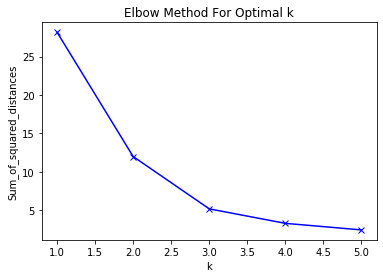

In [16]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
km = KMeans(n_clusters=3)
km.fit(vectors)
y = km.predict(vectors)
df_base['Cluster Class'] = pd.Series(y, index=df_21.index)

Text(0.5, 1.0, 'Incorrect Number of Blobs')

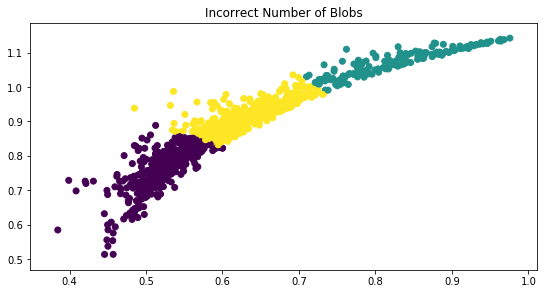

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.scatter(vectors[:, 0], vectors[:, 1], c=y)
plt.title("Incorrect Number of Blobs")

In [19]:
bycode = pd.read_excel(BYCODE)
index = pd.read_excel(INDEX, sheet_name=SETTLEMENT_TYPE)

df = inner_join(df_base,bycode,"code")
df = inner_join(df,index,"Settlement type code")
df = df[["Cluster Class","Settlement type"]]

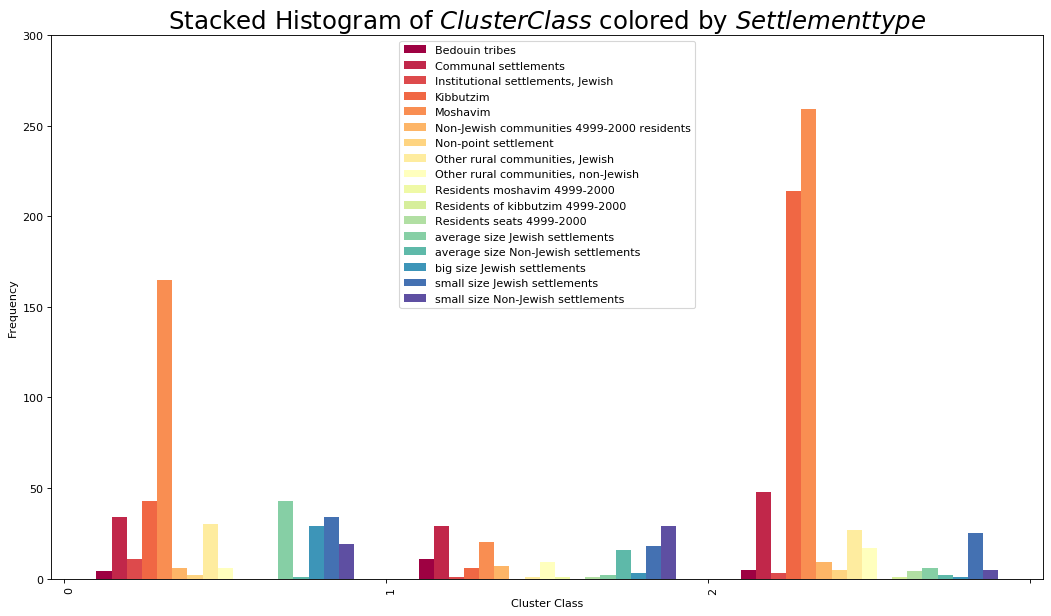

In [20]:
barchar_group(df,"Cluster Class","Settlement type",300)

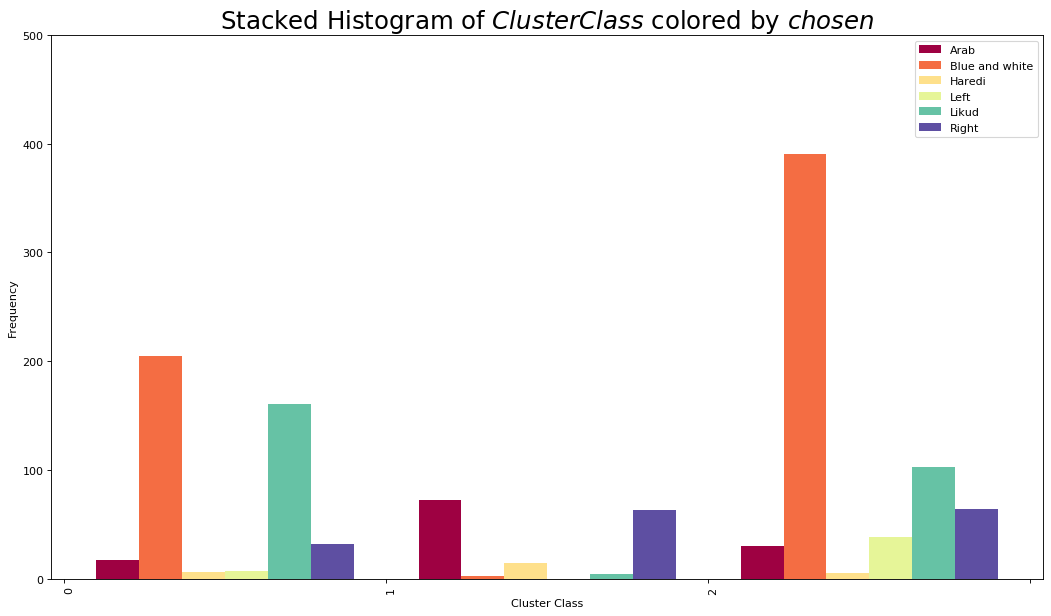

In [21]:
barchar_group(df_base,"Cluster Class","chosen",500)

In [22]:
from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 4)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(vectors)
        bic_score = gmm.bic(vectors)
        if bic_score < lowest_bic:
            lowest_bic = bic_score
            best_gmm = gmm

y = gmm.predict(vectors)
df_base['Cluster Class'] = pd.Series(y, index=df_21.index)

Text(0.5, 1.0, 'Incorrect Number of Blobs')

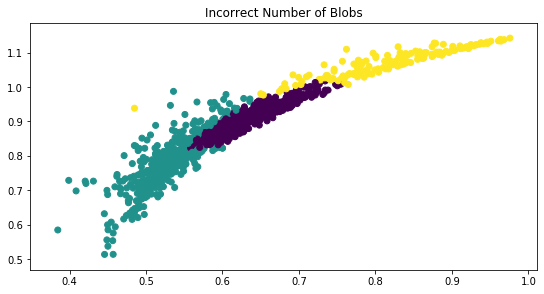

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.scatter(vectors[:, 0], vectors[:, 1], c=y)
plt.title("Incorrect Number of Blobs")

In [24]:
bycode = pd.read_excel(BYCODE)
index = pd.read_excel(INDEX, sheet_name=SETTLEMENT_TYPE)

df = inner_join(df_base,bycode,"code")
df = inner_join(df,index,"Settlement type code")
df = df[["Cluster Class","Settlement type"]]

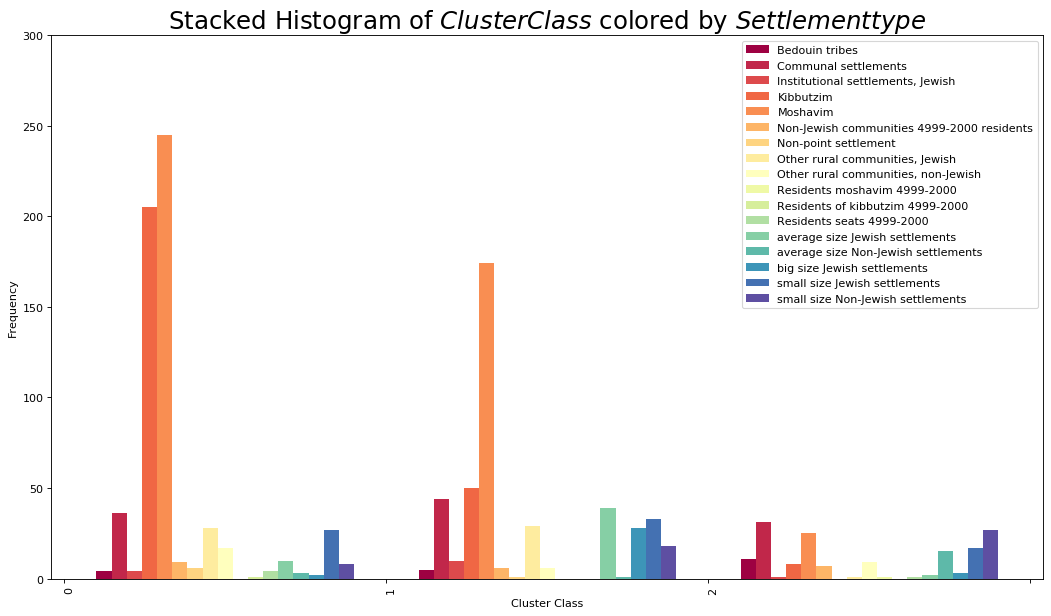

In [25]:
barchar_group(df,"Cluster Class","Settlement type",300)

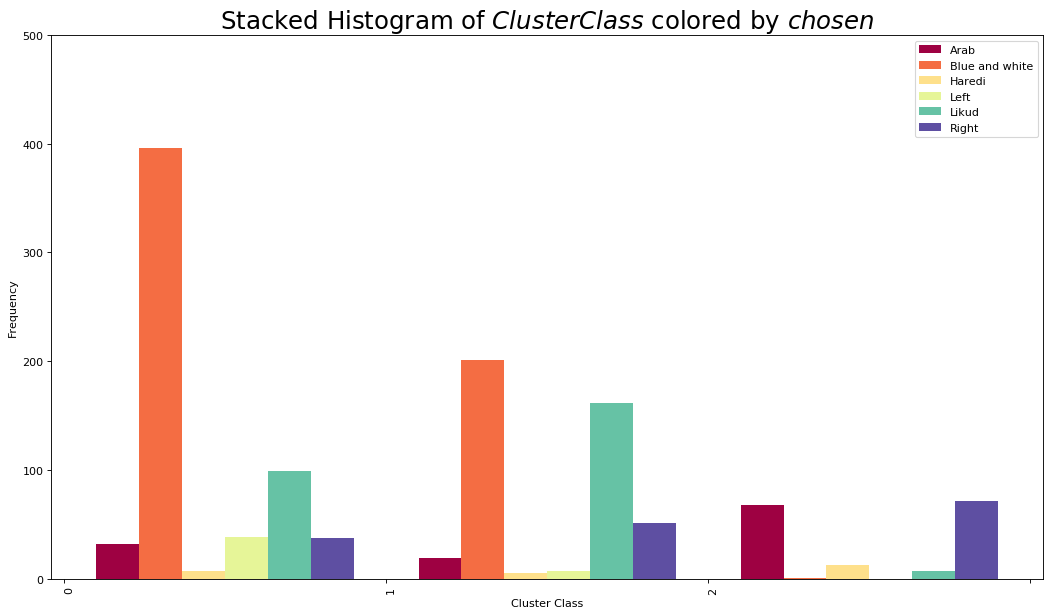

In [26]:
barchar_group(df_base,"Cluster Class","chosen",500)

In [27]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import  metrics
param_grid = {
    'n_estimators': [100, 150, 200, 250],  # The number of trees in the forest.
    'max_depth': [None, 50, 60, 70],  # The maximum depth of the tree.
    'max_features': ['sqrt', None],  # he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees.
}

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)
df21=df21[["Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)
df22=df22[["Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]


df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values.tolist()
df23=df23[["Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]

df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]

estimator = RandomForestRegressor(random_state=SEED)

rs = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,
                        scoring='neg_mean_squared_error', cv=5,
                        n_iter=1, verbose=1, random_state=SEED)

rs.fit(x_train,y_train)
predict_y = rs.predict(x_test)
actual=df23.iloc[:,-1].values

for  i in range(len(predict_y)):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


predection for ['AYYELET HASHAHAR'] is 591.3617996031746 while the true value is 585
predection for ['ELAT'] is 25090.24711904761 while the true value is 22636
predection for ['HAIFA'] is 145163.16691468234 while the true value is 144625
predection for ['SAKHNIN'] is 16436.161978174612 while the true value is 17085
predection for ['QAZRIN'] is 3630.9976210317463 while the true value is 3498


      Likud  Status Montzifali  Organizational affiliation  \
0       141               50.0                         1.0   
1       128               50.0                         1.0   
2       124               26.0                         2.0   
3        93               26.0                         2.0   
4        84               50.0                         1.0   
...     ...                ...                         ...   
2419  21340                0.0                         NaN   
2420  64380                0.0                         NaN   
2421  59798                0.0                         NaN   
2422     79               73.0                         NaN   
2423     60               73.0                         NaN   

      Planning Commission  Settlement type  
0                   634.0                4  
1                   634.0                4  
2                   151.0                4  
3                   151.0                4  
4                   634.0     

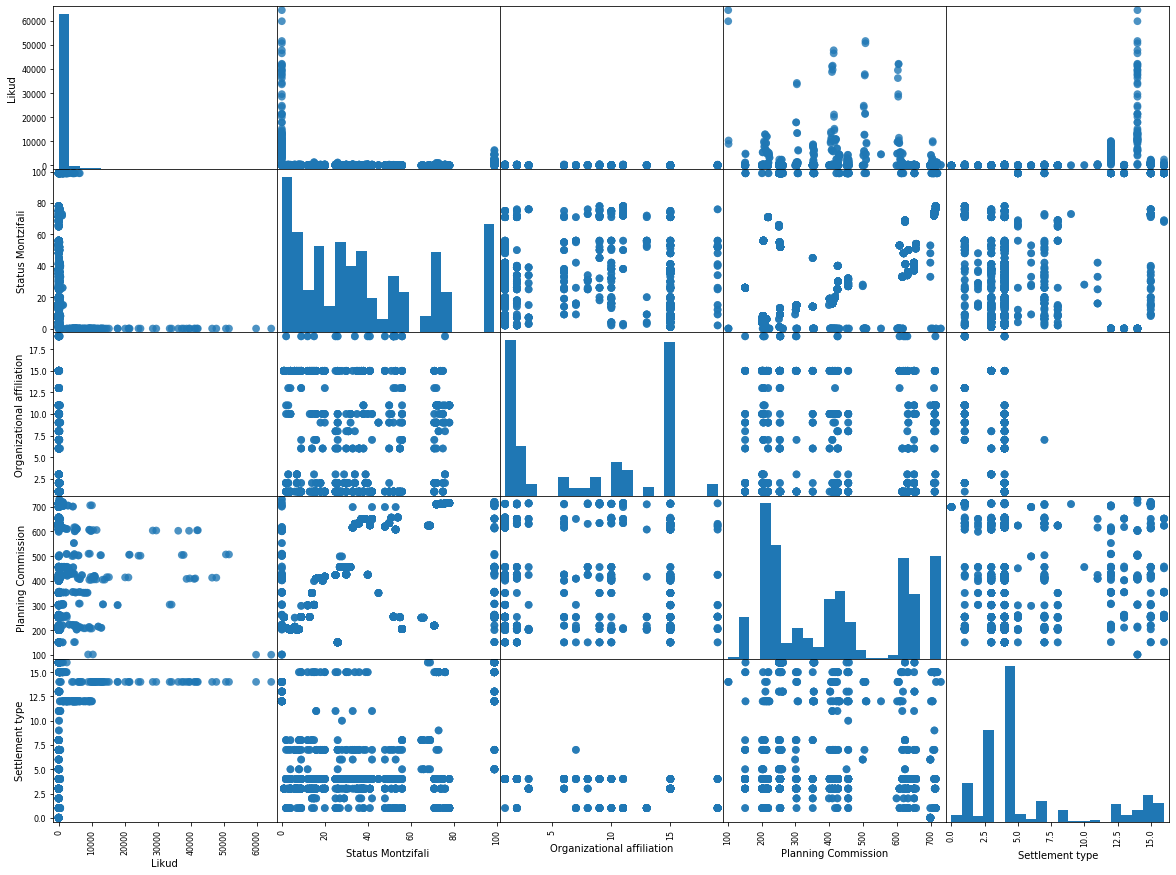

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import  metrics



le = LabelEncoder()

param_grid = {'n_estimators':[50,100,150,200,250,300], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

bycode = pd.read_excel(BYCODE)
sett_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
natru = pd.read_excel(INDEX,sheet_name=NATURAL)


df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)


df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values.tolist()


df=pd.concat([df21, df22])

df =  df[["Likud","code"]]
df = inner_join(df,bycode,"code")
df = inner_join(df,sett_type,"Settlement type code")
#df = inner_join(df,natru,"Natural area code")



df = df.drop(["code","Natural area code","Religion code","name","Settlement type code","District code","Subdistrict code"],axis = 1)

df['Settlement type'] = le.fit_transform(df['Settlement type'])
print(df)

pd.plotting.scatter_matrix(df,  figsize=(20, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)
plt.show()

In [31]:
x =  df.drop("Likud",axis=1)
y = df["Likud"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=SEED)

rs = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=20)),param_grid,cv=5,n_jobs=-1)

rs.fit(x_train, y_train)
adb=rs.best_estimator_
predict_y = adb.predict(x_test)
metrics.mean_squared_error(predict_y,y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
def getdataRegress(num , RF ,n=None):
    
        df = get_data(SETTELMENT,num)
        df = remove_small_parties(df,135720)
        df = unite_parties(df)
        if RF:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes"]]
        if n == 1:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Haredi","Right","Arab","Left","valid votes","Blue and white"]]
        elif n == 2:
            return df[["committee code","Voters","Disqualified","Holders of voting rights",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes","Likud"]]
        else:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Blue and white","Haredi","Right","Left","valid votes","Arab"]

       



from sklearn.ensemble import AdaBoostRegressor

df21=getdataRegress(21,False,1)
df22=getdataRegress(22,False,1)
df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["JERUSALEM","BENE BERAQ","SAKHNIN","KARMI'EL","DALIYAT AL-KARMEL"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Haredi","Right","Arab","Left","valid votes","Blue and white"]]
print(df22)
df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]
param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

rs = RandomizedSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_iter = 10,n_jobs=-1)
rs.fit(x_train, y_train)
ADB_best=rs.best_estimator_
adb = AdaBoostRegressor(ADB_best)
adb.fit(x_train, y_train)
predict_y = adb.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1



df21=getdataRegress(21,False,2)
df22=getdataRegress(22,False,2)
df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes","Likud"]]
print(df22)
df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]
param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

rs = RandomizedSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_iter = 10,n_jobs=-1)
rs.fit(x_train, y_train)
ADB_best=rs.best_estimator_
adb = AdaBoostRegressor(ADB_best)
adb.fit(x_train, y_train)
predict_y = adb.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1







In [ ]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import  metrics
param_grid = {
    'n_estimators': [100, 150, 200, 250],  # The number of trees in the forest.
    'max_depth': [None, 50, 60, 70],  # The maximum depth of the tree.
    'max_features': ['sqrt', None],  # he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees.
}

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)
df21=df21[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)
df22=df22[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]


df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values.tolist()
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]

df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]

estimator = RandomForestRegressor(random_state=SEED)

rs = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,
                        scoring='neg_mean_squared_error', cv=5,
                        n_iter=1, verbose=1, random_state=SEED)

rs.fit(x_train,y_train)
predict_y = rs.predict(x_test)
actual=df23.iloc[:,-1].values

for  i in range(len(predict_y)):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        
        


In [87]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import itertools

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = SEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)




df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)




bycode = pd.read_excel(BYCODE)
settlment_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)

bycode.fillna(0)

def label(row,total):
    prop  = row["Disqualified"] / total
    
    val = 0
    
    if prop > 0.02:
        val = 1
    
    return val

total = df21["Disqualified"].sum()
df21['class'] = df21.apply(lambda row : label(row, total), axis = 1) 

total = df22["Disqualified"].sum()
df22['class'] = df22.apply(lambda row : label(row, total), axis = 1)

total = df23["Disqualified"].sum()
df23['class'] = df23.apply(lambda row : label(row, total), axis = 1)

df=pd.concat([df21, df22])

df = inner_join(df,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df.drop(["name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1, inplace = True)
df= df.fillna(0)
y = df["class"]
x = df.drop("class",axis = 1)

rs.fit(x,y)



df = inner_join(df23,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df.drop(["name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1, inplace = True)
df= df.fillna(0)
test_y = df["class"]
test_x = df.drop("class",axis = 1)

y_predict = rs.predict(test_x)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


1.0

In [88]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[1202    0]
 [   0   10]]


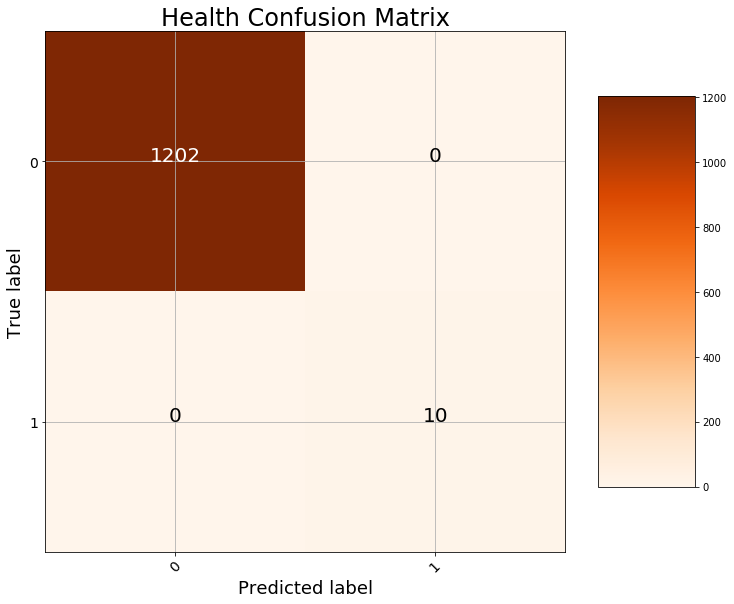

In [90]:
cm = confusion_matrix(test_y, y_predict)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Health Confusion Matrix')